In [42]:
import tensorflow as tf
from tensorflow import keras 
import tensorflow.keras.backend as kb
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers


import numpy as np

from sklearn import decomposition
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D

In [43]:
#load packages

%matplotlib inline

import matplotlib.pyplot as plt
from numpy import genfromtxt
from spectral import *


In [44]:
def index_formula(blue, green, red, nir, swir1, swir2, indstr):
  
    if (indstr=="TSC_BRI"):  #Taseeled Cap Brightness
        
        indval = 0.3037*blue + 0.2793*green + 0.4743*red + 0.5585*nir + 0.5082*swir1 + 0.1863*swir2
    
    elif (indstr=="MSAVI"):  # Modified Soil Adjusted Vegetation Index
    
        indval = (2*nir+1-np.sqrt((2*nir+1)*(2*nir+1)-8*(nir-red)))/2
    
    elif (indstr=="MNDWI"):  # Modified Normalised Difference Water Index
    
        indval = (green-swir1)/(green+swir1)
    
    elif (indstr=="NDBI"): # Normalised difference built-up index
    
        indval = (swir1-nir)/(swir1+swir2)
    
    elif (indstr=="NDVI"):  # Normalised difference vegetation index
    
        indval = (nir-red)/(nir+red)
    
    elif (indstr=="BUI"):  # Built-up index
    
        ndbi =  index_formula(blue, green, red, nir, swir1, swir2, "NDBI")
        ndvi =  index_formula(blue, green, red, nir, swir1, swir2, "NDVI")
        indval = ndbi - ndvi
    
    elif (indstr=="BAEI"): # Built-up area extraction index
        L=0.3
        indval = (red+L)/(green+swir1)
    
    elif (indstr=="NBI"): # New built-up index
    
        indval = swir1*red/nir
    
    elif (indstr=="VIBI"): #  Vegetation index built-up index
    
        ndbi =  index_formula(blue, green, red, nir, swir1, swir2, "NDBI")
        ndvi =  index_formula(blue, green, red, nir, swir1, swir2, "NDVI")
        indval = ndvi/(ndvi+ndbi)
    
    elif (indstr=="IBI"): # Index-based built-up index
    
        ndbi =  index_formula(blue, green, red, nir, swir1, swir2, "NDBI")
        savi =  index_formula(blue, green, red, nir, swir1, swir2, "SAVI")
        mndwi =  index_formula(blue, green, red, nir, swir1, swir2, "MNDWI")
        indval = (ndbi - (savi+mndwi)/2)/(ndbi+(savi+mndwi)/2)
    
    elif (indstr=="SAVI"): # Soil adjusted vegetation index
    
        L=0.5
        indval = ((nir-red)/(nir+red+L))*(1+L)
    
    elif (indstr=="UI"): # Urban index 
    
        indval = ((swir2-nir)/(swir2+nir)+1.0)*100
    
    elif (indstr=="NDTI"): #Normalised difference tillage index
    
        indval = (swir1-swir2)/(swir1+swir2)
    
    elif (indstr=="NBUI"):  #New built-up urban index 
    
        indval = (red-swir1)/(red+swir1) + (swir2 - swir1)/(swir2+swir1)
    
    elif (indstr=="VAUI"):  #Vegetation adjusted urban index 
    
        msavi =  index_formula(blue, green, red, nir, swir1, swir2, "MSAVI")
        indval = (red-swir1)/(red+swir1) + (swir2 - swir1)/(swir2+swir1) - msavi
    
    elif (indstr=="NDWI"):  #Normalised difference water index 
    
        msavi =  index_formula(blue, green, red, nir, swir1, swir2, "MSAVI")
        indval = (red-swir1)/(red+swir1) + (swir2 - swir1)/(swir2+swir1) - msavi
    
    elif (indstr=="MVAUI"):  #MNDWI and Vegetation adjusted urban index 
    

        msavi =  index_formula(blue, green, red, nir, swir1, swir2, "MSAVI")
        mndwi =  index_formula(blue, green, red, nir, swir1, swir2, "MNDWI")
        indval = (red-swir1)/(red+swir1) + (swir2 - swir1)/(swir2+swir1) - msavi + mndwi
    
    elif (indstr=="WVAUI"):  #NDWI and Vegetation adjusted urban index 
    
        msavi =  index_formula(blue, green, red, nir, swir1, swir2, "MSAVI")
        ndwi =  index_formula(blue, green, red, nir, swir1, swir2, "NDWI")
        indval = (red-swir1)/(red+swir1) + (swir2 - swir1)/(swir2+swir1) - msavi + ndwi
    
    elif (indstr=="DBSI"):  #NDWI and Vegetation adjusted urban index 
    
        msavi =  index_formula(blue, green, red, nir, swir1, swir2, "MSAVI")
        indval = (swir1-green)/(swir1+green) - msavi
    
    elif (indstr=="BSI"):  #NDWI and Vegetation adjusted urban index 
    
        indval = ((swir1+red)-(nir+blue)) / ((swir1+red)+(nir+blue));
    
    elif (indstr=="BLUE"):  # Blue band
    
        indval = blue
    
    elif (indstr=="GREEN"):  # Green band
    
        indval = green
    
    elif (indstr=="RED"):  # Red band
    
        indval = red
    
    elif (indstr=="NIR"):  # Near Infrared band
    
        indval = nir
    
    elif (indstr=="SWIR1"):  # SWIR1 band
    
        indval = swir1
    
    elif (indstr=="SWIR2"):  # SWIR2 band
    
        indval = swir2
    


    return indval



In [45]:
def cal_indice(bandvals, indstr):
      
    blue=bandvals[0]
    green=bandvals[1]
    red=bandvals[2]
    nir=bandvals[3]
    swir1=bandvals[4]
    swir2=bandvals[5]
    
    return index_formula(blue, green, red, nir, swir1, swir2, indstr)

In [46]:
def create_indices(data, indices_list):
    ncol=len(indices_list)
    nrow=data.shape[0]
    indices=np.zeros((nrow, ncol))

    tpdata=np.transpose(data)
    for i, indstr in enumerate(indices_list):
        indices[:, i]=cal_indice(tpdata, indstr)
    
    return indices

In [47]:
def outputenvifile(clsarr, path, h, fstem, bandnames, bands, datatype, description):
    newhdrfile=path+'/'+fstem+'.hdr'
    newimgfile=path+'/'+fstem+'.img'
    h['band names']=bandnames
    h['bands']=bands
    h['data type']=datatype
    h['description']=description
    envi.write_envi_header(newhdrfile, h)
    clsarr.tofile(newimgfile)



In [48]:
# Load preclassified data for candidates of Vegetation, 

#dirc='/g/data1/u46/pjt554/urban_change_s2_full_sites/brisbane'
dirc='/home/ptan/s2data/test_sites_peter'

path=dirc

#filestem='arid_2015'
filestem='Tasmania_2015'

hdrfile=path+'/'+filestem+'_blue.hdr'
h = envi.read_envi_header(hdrfile)
irow=np.int32(h['lines'])
icol=np.int32(h['samples'])

In [49]:
#rawfeaturelist=['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1','SWIR2']
rawfeaturelist=['blue', 'green', 'red', 'nir', 'swir1','swir2']

wholedata=[]
for specband in rawfeaturelist:
    imgfile=path+'/'+filestem+'_'+specband+'.img'
    oneband=np.fromfile(imgfile, dtype=np.float32)
    wholedata.append(oneband)

wholedata=np.array(wholedata)

In [50]:
wholedata.shape

(6, 995888)

In [51]:
indices_list=['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'TSC_BRI', 'MNDWI', 'NDBI', 'NDVI', 'NDTI']

In [52]:
allindices = create_indices(np.transpose(wholedata), indices_list)

In [53]:
allindices.shape

(995888, 11)

In [54]:
modelfilename='/home/ptan/s2data/brisbane/2018/gbi_fraction_model.h5'

bri_model = models.load_model(modelfilename)

In [55]:
asfrac= bri_model.predict(allindices)
mpfrac=np.transpose(asfrac)

In [56]:
fstem=filestem+'_gre_bare_inf_fractions'
bandnames = ['green_fractions', 'bare_fractions', 'infrastructure_fraction']
bands=3
datatype=4
description='Green bare infrastructure factions'
outputenvifile(mpfrac, path, h, fstem, bandnames, bands, datatype, description)

In [57]:
irow=np.int32(h['lines'])
icol=np.int32(h['samples'])
pimg=asfrac.reshape(irow, icol, 3)

mmpimg=np.zeros((irow, icol, 3), dtype=np.float32)
mmpimg[:, :, 0]=pimg[:, :, 2]
mmpimg[:, :, 1]=pimg[:, :, 0]
mmpimg[:, :, 2]=pimg[:, :, 1]

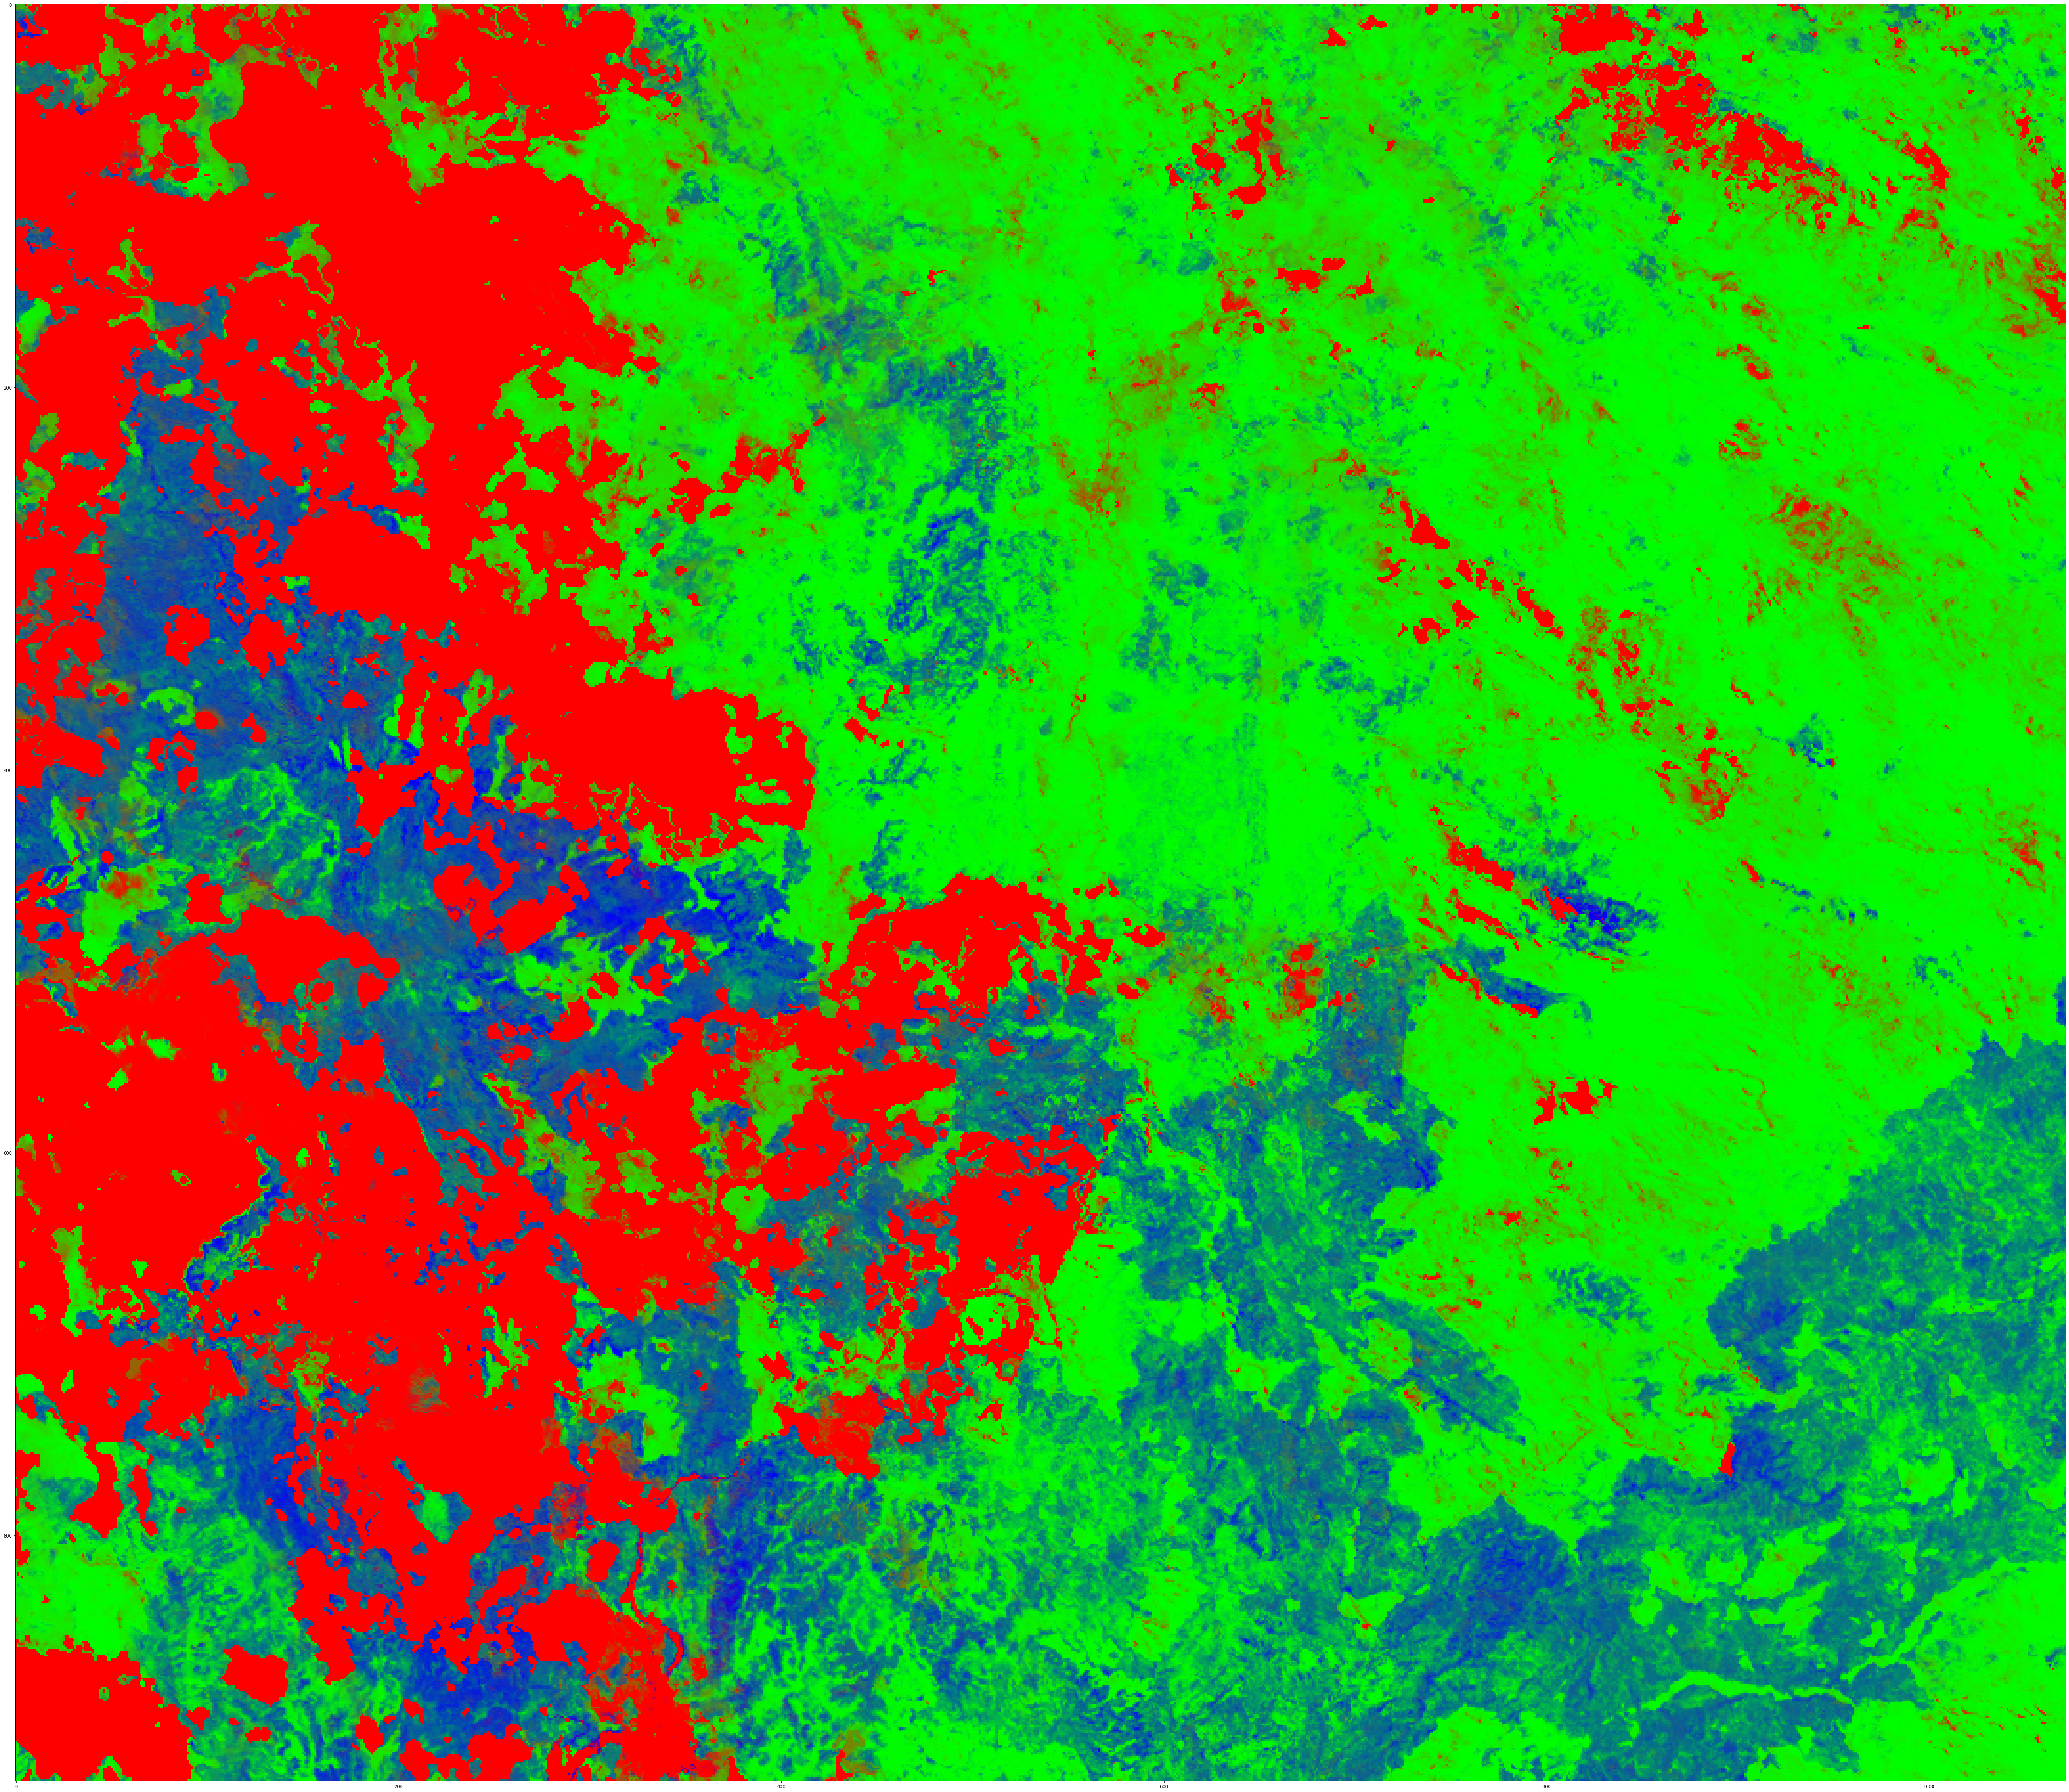

In [58]:
fig = plt.figure()
fig.set_size_inches(80,80)
plt.imshow(mmpimg, vmin=0.0, vmax=1.0)
filename=path+'/'+filestem+'_fractions_rgb.png'
plt.imsave(filename, mmpimg)
